Because in the part 1 of this week's hands-on, we have installed these package. But if you only work on the part 2, make sure your install these packages before working on this notebook. If you work on Jupyterlab, you will need to install it again every time you start the server.

In [5]:
#!pip install minisom
#!pip install rdkit-pypi
#!pip install Mordred

In [6]:
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
from rdkit import Chem
import re
import minisom
from minisom import MiniSom
import matplotlib.pyplot as plt


## Recap about Self-organizing map (SOM)

<a title="Chompinha, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:TrainSOM.gif"><img width="256" alt="TrainSOM" src="https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif"></a>

The self-organizing map is a grid in the high-dimensional space spanned by your dataset(the number of dimension is the number of features in your dataset).  For each node in the map, its coordinate in the multi-dimensional space is called the weight of the node. The training process of the self-organizing map is essentially updating the weight(i.e. coordinate) of the nodes to make them as close as possible to the dataset points.

By the end of the training process, each data point in the dataset will find a nearest node in the map, and this node is called the `best matching unit` of this data point. Though the training happens in the high-dimensional space, you can display the map as a two-dimensional grid(Imagine you flatten a crumpled paper). And on the two-dimensional grid, you can show the location of each `best matching unit`, which reflects the clustering of your datapoints in the high-dimensional space.


In [7]:
df = pd.read_csv("Ampicillin_final.csv")
df.head()

,Unnamed: 0,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,...,nAromAtom,nAromBond,naRing,SpAbs_D,nH,nO,nN,nHBAcc,nHBDon,SLogP
0,0,1268,2-[2-(Benzylamino)-2-oxo-1-[(2-phenylacetyl)am...,NaN,441.5,C23H27N3O4S,133.0,645.0,0.1,31,...,12,12,2,375.75789869237155,27,4,3,5,4,1.9246
1,1,2173,"6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...","6-{[amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...",348.4,C16H18N3O4S-,141.0,556.0,-0.5,24,...,6,6,1,234.9889721189548,18,4,3,6,2,-1.0166
2,2,2174,Alpen,Guicitrine|Ampicin|Deripen|Wypicil|6-{[amino(p...,349.4,C16H19N3O4S,138.0,562.0,-1.1,24,...,6,6,1,234.9889721189548,19,4,3,5,3,0.3181
3,3,2271,"3,3-Dimethyl-7-oxo-6-{[{[(2-oxo-1-imidazolidin...",MLS006011456|CHEMBL4747314|DTXSID20860542|BCP1...,461.5,C20H23N5O6S,173.0,844.0,0.1,32,...,6,6,1,376.6742576082671,23,6,5,6,4,0.0942
4,4,2282,1-Ethoxycarbonyloxyethyl 6-[(2-amino-2-phenyla...,CHEMBL1625790|DTXSID20860547|DB-051870|FT-0602...,465.5,C21H27N3O7S,163.0,756.0,2.7,32,...,6,6,1,420.90118704390926,27,7,3,9,2,1.2958


In [8]:
df.keys()

Index(['Unnamed: 0', 'cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea',
       'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds',
       'inchi', 'isosmiles', 'inchikey', 'iupacname', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation', 'nAromAtom', 'nAromBond', 'naRing', 'SpAbs_D', 'nH', 'nO',
       'nN', 'nHBAcc', 'nHBDon', 'SLogP'],
      dtype='object')

In [9]:
sub = df[['isosmiles','xlogp','polararea', 'complexity', 'nAromAtom','nAromBond','naRing','SpAbs_D','nH','nO','nN','nHBAcc','nHBDon','SLogP']].copy()

`polararea`:
The polar surface area (PSA) or topological polar surface area (TPSA) of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms. 
PSA is a commonly used medicinal chemistry metric for the optimization of a drug's ability to permeate cells. Molecules with a polar surface area of greater than 140 angstroms squared tend to be poor at permeating cell membranes.

In [10]:
sub['index']=list(range(len(sub)))
sub.set_index('index',drop=True,inplace=True)

In [11]:
sub.insert(0, 'Number', range(1, 1+ len(df)))

In [12]:
sub.shape

(1170, 15)

In [13]:
sub.head()

,Number,isosmiles,xlogp,polararea,complexity,nAromAtom,nAromBond,naRing,SpAbs_D,nH,nO,nN,nHBAcc,nHBDon,SLogP
index,,,,,,,,,,,,,,,
0,1,CC1(C(NC(S1)C(C(=O)NCC2=CC=CC=C2)NC(=O)CC3=CC=...,0.1,133.0,645.0,12,12,2,375.75789869237155,27,4,3,5,4,1.9246
1,2,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,-0.5,141.0,556.0,6,6,1,234.9889721189548,18,4,3,6,2,-1.0166
2,3,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,-1.1,138.0,562.0,6,6,1,234.9889721189548,19,4,3,5,3,0.3181
3,4,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)...,0.1,173.0,844.0,6,6,1,376.6742576082671,23,6,5,6,4,0.0942
4,5,CCOC(=O)OC(C)OC(=O)C1C(SC2N1C(=O)C2NC(=O)C(C3=...,2.7,163.0,756.0,6,6,1,420.90118704390926,27,7,3,9,2,1.2958


We will use the Polar surface area,number of Nitrogen and Oxygen atoms, number of aromatic atoms from our dataset to train the SOM. We can learn from the definition  of polar surface area that Nitrogen and Oxygen atoms have great influence on PSA. Also, The presence of aromatic rings also affects the polarity of the molecule.

Note that only the numerical data can be used to train SOM, but the categorical data can be useful when we visualize the SOM later.

You need to normalize the data before training a SOM. But if you are quite sure that some properties are quite important for your result, You don't have to normalize the data 

Formula of how to normalize the data  
$X = \frac{(x-\overline{x})}{\sigma(x)}$ 

In [14]:
traindata = sub[['polararea','nO','nN','nAromAtom']].values
traindata = (traindata - np.mean(traindata, axis=0)) / np.std(traindata, axis=0)

In [16]:
traindata[1]

array([-0.0471126 , -0.68829018, -0.1081259 , -0.21661565])

In [30]:
sub['nAromAtom'].describe()

count    1170.000000
mean        6.364957
std         1.685535
min         0.000000
25%         6.000000
50%         6.000000
75%         6.000000
max        18.000000
Name: nAromAtom, dtype: float64

Train the SOM with this `traindata` array.

Important parameters: 

the minimum number of node is $5*\sqrt{N}$ which N equals to the number of data point in training data

So the minimum height and width = $\sqrt{5*\sqrt{N}}$

`sigma`: it determines the radius of neighbors on the map. Note that when we update the location of each node in the map, its neighbors in the map will be updated together. sigma determines a radius that all the other nodes within this range will be regarded as neighbors.

`learning_rate`: it determines how much weights are updated in each iteration of training.

In [17]:
# Define a SOM
height = 16
width = 16
# Define a MiniSom object
som = MiniSom(width, height, traindata.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=0) 

# Initialize the weights by PCA
som.pca_weights_init(traindata)

# trains the SOM with 400 iterations
som.train(traindata, 400) 

We can visualize the trained SOM by displaying all the `best matching unit` in the grid.

This will use the `winner()` method of this `MiniSom` object. It takes in the training data value of one data point (i.e. one row in our `traindata` array), and returns the coordinate of its `best matching unit` in the grid.

For example:

In [18]:
som.winner(traindata[0])

(14, 14)

This means that the `best matching unit` of the our first data point is the (14,14) node in the grid. 

Then we can write a loop to display the `best matching unit` of all our data points on our map.

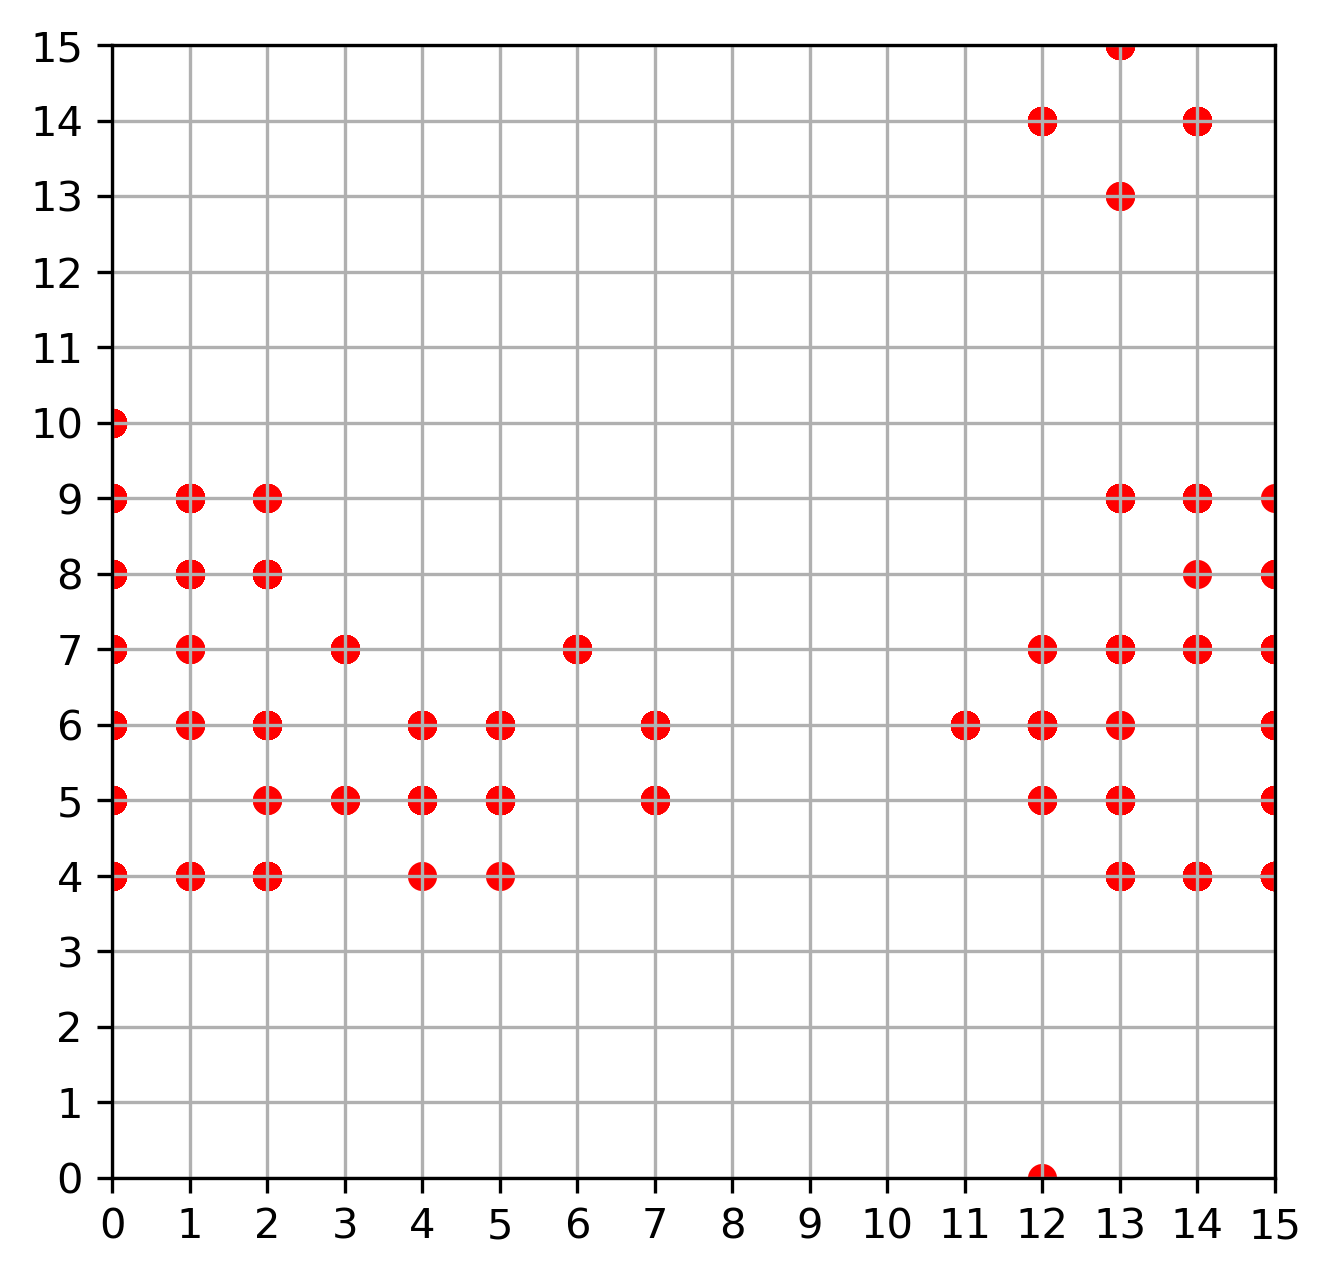

In [19]:
fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(traindata):
    # find the best matching unit of the datapoint
    w = som.winner(datapoint)
    x_coord = w[0]
    y_coord = w[1]
    
    #plot the best matching unit
    plt.scatter(x_coord,y_coord,c='red')
    
#visualize the grid    
plt.ylim(0,height-1)
plt.xlim(0,width-1)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
plt.grid()

### Exercise 1: Please find the coordinate of the `best matching unit` of Ampicllin in the grid

`Hint`: Ampicllin is the second compound in the dataset.

In [23]:
w = som.winner(traindata[1])
w

(11, 6)

We would find from the above plot that, the amount of displayed points is less than the number of data points in our training data. This is because that many data points share the same node as the `best matching unit`. 

When plot the `best matching unit` we can add a small random offset to their coordinate in the grid to make them distinguishable. And the serial number of their corresponding datapoint can be displayed next to the points in the grid.

Also, we can color-encode each `best matching unit` by the category of their corresponding datapoint.

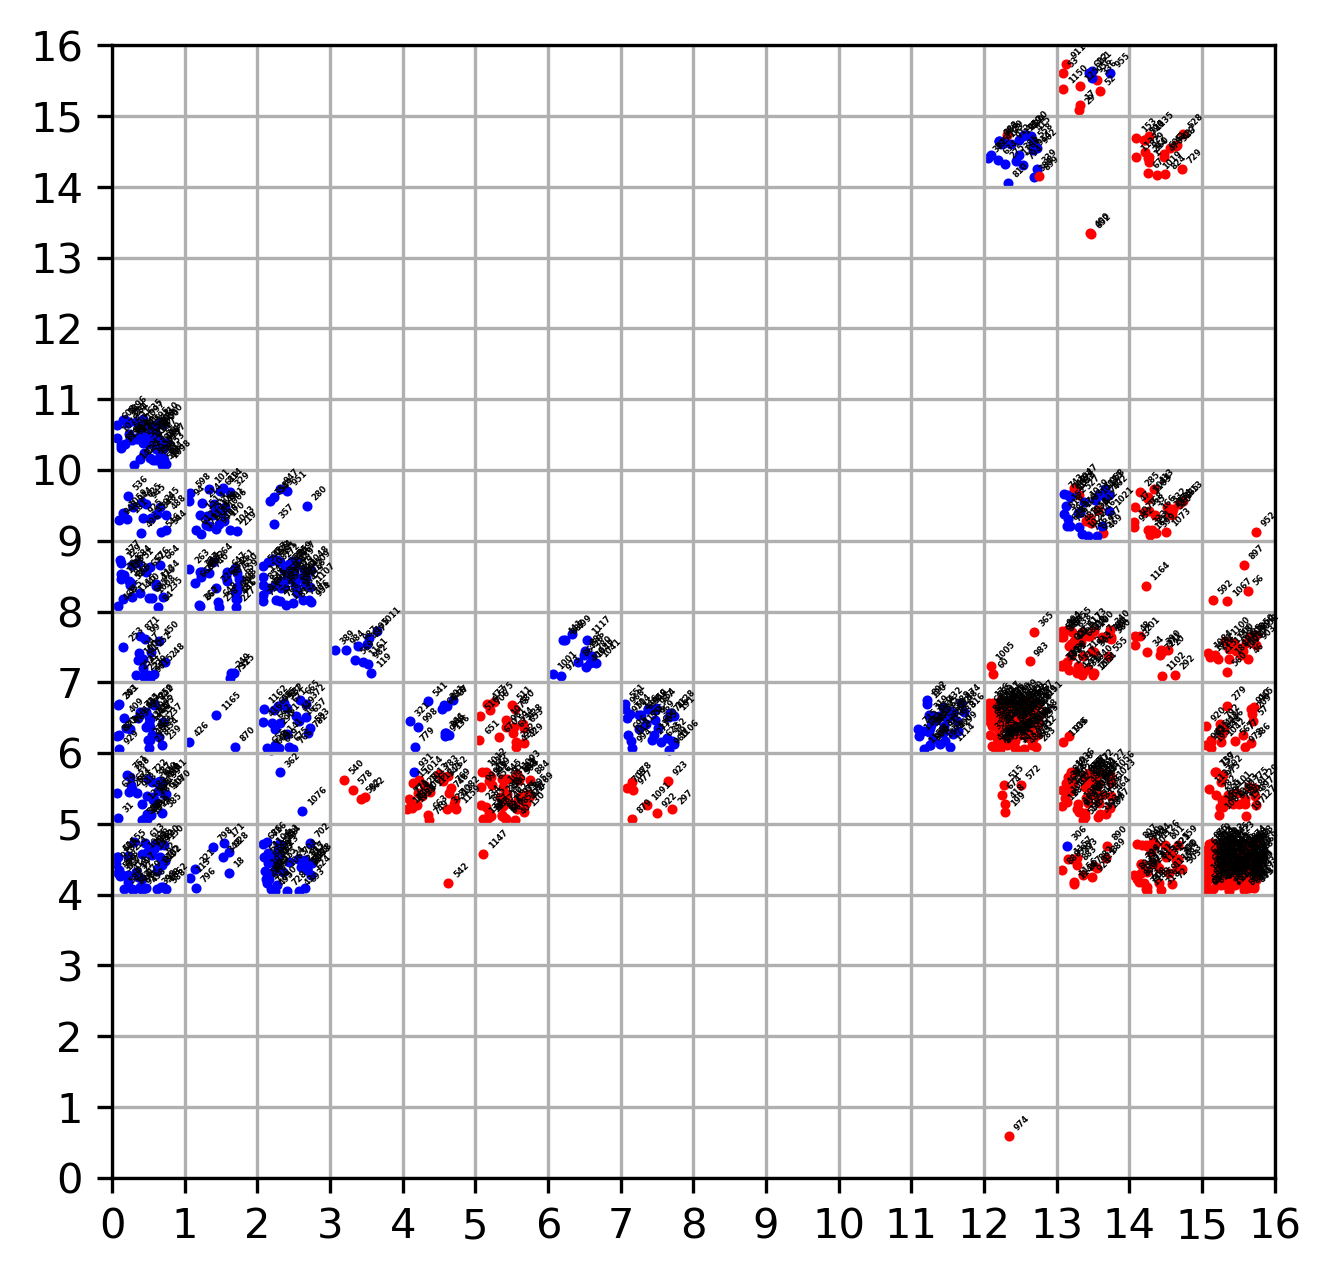

In [21]:
fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(traindata):
    w = som.winner(datapoint)  
    
    #add a random offset to their coordinate in the grid
    x_coord = w[0]+np.random.uniform(0.05,0.75)
    y_coord = w[1]+np.random.uniform(0.05,0.75)
    
    # color-encode by Group
    # the 'polararea' less than 140 means that the molecules are good at permeating cell membranes.
    if sub.iloc[index]['polararea'] < 140:
        plt.scatter(x_coord,y_coord,c='red',s=2)
    else:
        plt.scatter(x_coord,y_coord,c='blue',s=2)
    #red means good at permeating. Blue means poor at permeating
    #add label next to each point.
    plt.text(x_coord+0.05,y_coord+0.05,sub.iloc[index]['Number'],
            horizontalalignment='left', verticalalignment='bottom',
            rotation=45, fontsize=2, weight='semibold')
    
plt.xlim(0,10)
plt.ylim(0,10)
ax.set_xticks(range(width+1))
ax.set_yticks(range(height+1))
plt.grid()

plt.show()

### Exercise 2: make a new plot like the one right above, but display each `best matching unit` corresponding to compounds that have 1 aromatic rings in red, and the other `best matching unit` in blue.

In [38]:
sub.iloc[:]['naRing']

index
0       2
1       1
2       1
3       1
4       1
       ..
1165    1
1166    1
1167    2
1168    1
1169    1
Name: naRing, Length: 1170, dtype: int64

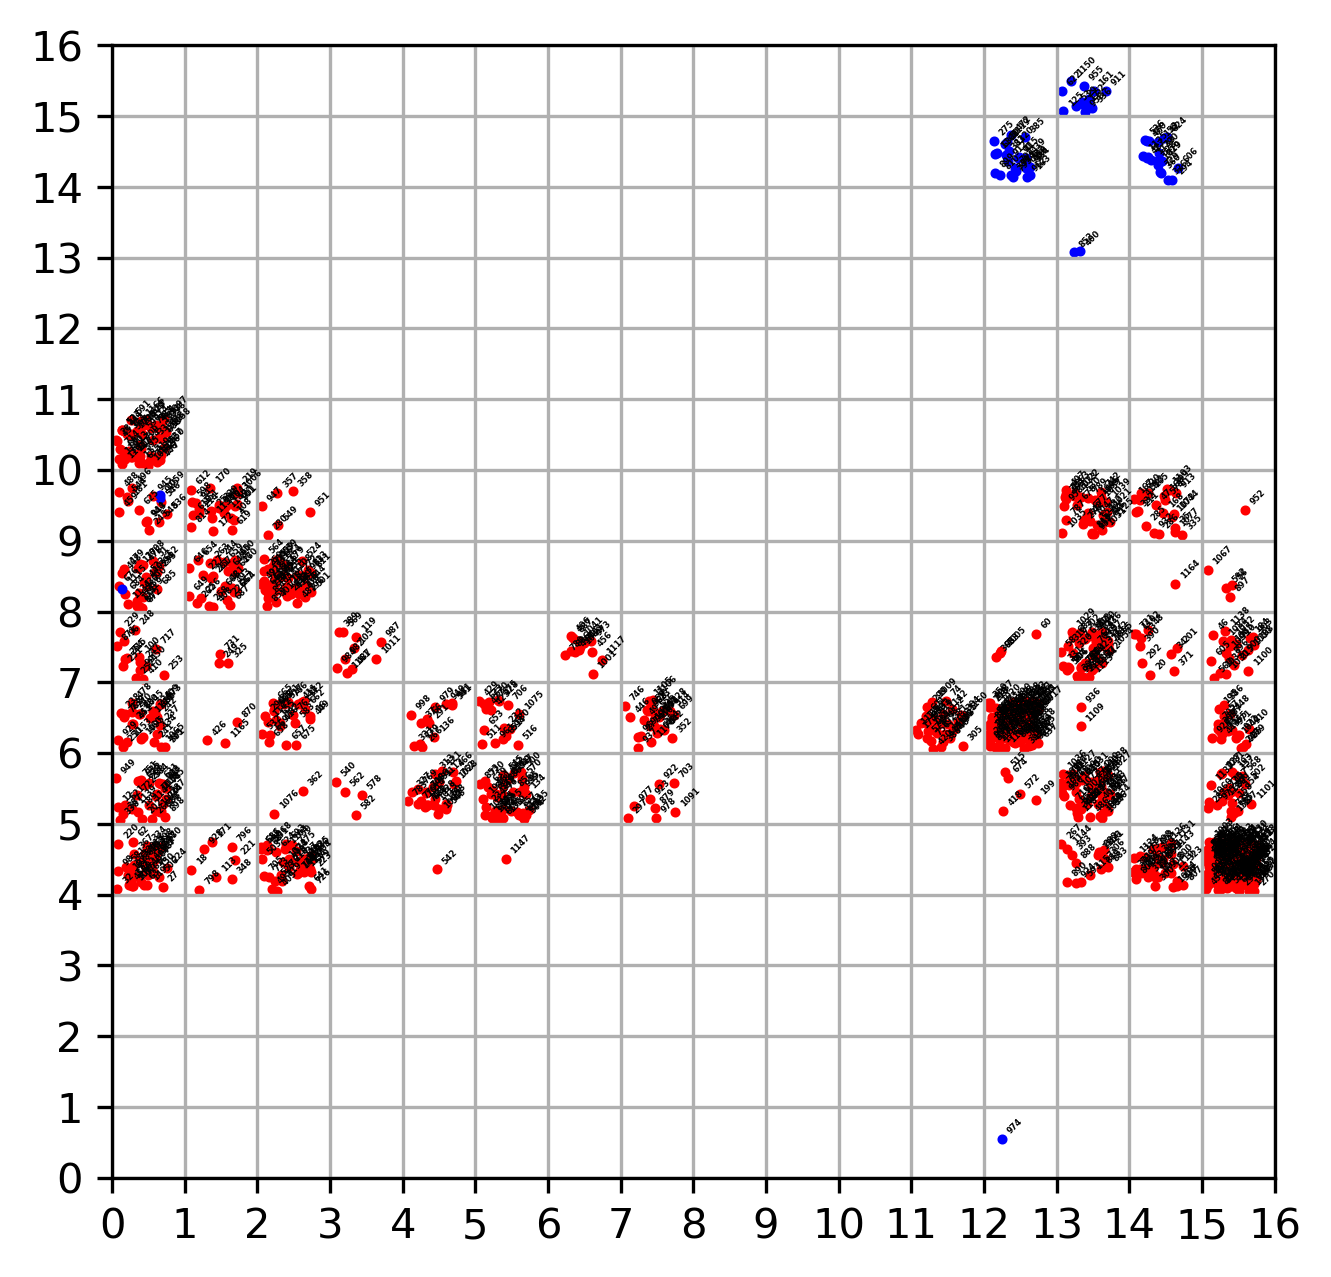

In [32]:
fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(traindata):
    w = som.winner(datapoint)  
    
    #add a random offset to their coordinate in the grid
    x_coord = w[0]+np.random.uniform(0.05,0.75)
    y_coord = w[1]+np.random.uniform(0.05,0.75)
    
    # color-encode by Group
    # the 'naRing' equal 1 means that the molecules are good at permeating cell membranes.
    if sub.iloc[index]['naRing'] == 1:
        plt.scatter(x_coord,y_coord,c='red',s=2)
    else:
        plt.scatter(x_coord,y_coord,c='blue',s=2)
    #red means good at permeating. Blue means poor at permeating
    #add label next to each point.
    plt.text(x_coord+0.05,y_coord+0.05,sub.iloc[index]['Number'],
            horizontalalignment='left', verticalalignment='bottom',
            rotation=45, fontsize=2, weight='semibold')
    
plt.xlim(0,10)
plt.ylim(0,10)
ax.set_xticks(range(width+1))
ax.set_yticks(range(height+1))
plt.grid()

plt.show()

I choose NO.125[Red] and NO.956[Blue] molecules to see the structure of these molecules by using RDkit.

In [39]:
SMILES = []
for molecule in df["isosmiles"]:
    SMILES.append(Chem.MolFromSmiles(molecule))

[17:26:12] WARNING: not removing hydrogen atom without neighbors
[17:26:12] WARNING: not removing hydrogen atom without neighbors
[17:26:12] WARNING: not removing hydrogen atom without neighbors
[17:26:12] WARNING: not removing hydrogen atom without neighbors
[17:26:13] WARNING: not removing hydrogen atom without neighbors
[17:26:13] WARNING: not removing hydrogen atom without neighbors
[17:26:13] WARNING: not removing hydrogen atom without neighbors
[17:26:13] WARNING: not removing hydrogen atom without neighbors


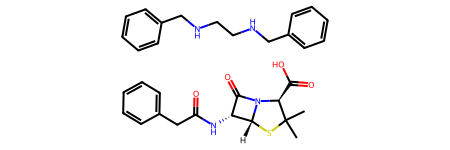

In [40]:
SMILES[124]#Low polar surface area 

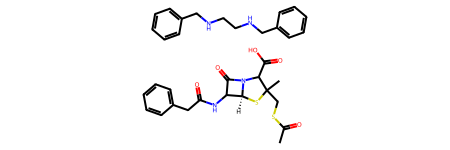

In [41]:
SMILES[955]#High polar surface area

However, we can find that there are some molecules' structures are different between the RDkit and the Pubchem database. It is just because RDkit is a free package, it won't maintance very often. And RDkit does not perform very well when reading the smiles encoding for some of the more complex structures.

So here I just use these two molecules to demonstrate how to use Rdkit.

## Evaluate the quantization and topographic error of SOM

* Quantization error: Average distance between each data point and its `Best matching unit`
* Topographic error: the proportion of all data vectors for which first and second `Best matching unit` are not adjacent units.Measures topology preservation.


In [42]:
print('Topographic error: ', som.topographic_error(traindata))
print('Quantization error: ', som.quantization_error(traindata))

Topographic error:  0.11367521367521367
Quantization error:  0.2626952927203822


Let's tune the size of the map,  and see if we can find lower topographic error and quantization error.
Assume it's a square grid.

In [43]:
size_list = np.arange(5,30,1)
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    som1 = MiniSom(size_list[i], size_list[i], traindata.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=0)
    som1.pca_weights_init(traindata)
    som1.train(traindata, 400)
    te[i] = som1.topographic_error(traindata)
    qe[i] = som1.quantization_error(traindata)

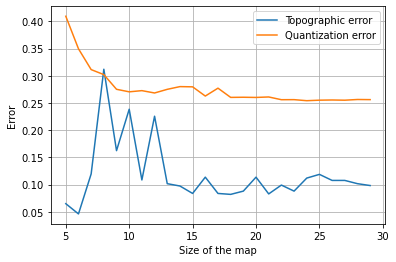

In [44]:
plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Size of the map')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


### Exercise 3: Please write a loop to see how topographic error and quantization error change with the parameter `sigma` from 0.5 to 5, then make a plot of topographic error and quantization error as function of sigma.

In [45]:
traindata.shape[1]

4

In [50]:
size_list = np.linspace(0.5,5,10)
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    som1 = MiniSom(22, 22, traindata.shape[1], sigma=size_list[i], learning_rate=0.5,neighborhood_function='gaussian', random_seed=0)
    som1.pca_weights_init(traindata)
    som1.train(traindata, 400)
    te[i] = som1.topographic_error(traindata)
    qe[i] = som1.quantization_error(traindata)

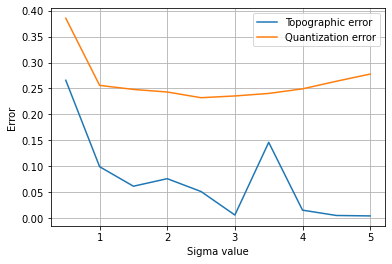

In [51]:
plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Sigma value')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()